<a href="https://colab.research.google.com/github/mancunian1792/LatentSpaceClustering_GenerativeModels/blob/main/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.cm as cm
import matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Model Definitions

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class encoder(nn.Module):
    def __init__(self, image_channels=3):
        super(encoder, self).__init__()
        self.conv2d1 = nn.Conv2d(image_channels, 32, kernel_size=4, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2d2 = nn.Conv2d(32,64, kernel_size=4, stride=2)
        self.conv2d3 = nn.Conv2d(64,128, kernel_size=4, stride=2)
        #self.conv2d4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.flatten = Flatten()
    
    def forward(self,x):
        x = self.conv2d1(x)
        x = self.relu1(x)
        x = self.conv2d2(x)
        x = self.relu1(x)
        x = self.conv2d3(x)
        x = self.relu1(x)
        #x = self.conv2d4(x)
        x = self.relu1(x)
        return self.flatten(x)

class decoder(nn.Module):
    def __init__(self, h_dim = 1024, image_channels=3):
        super(decoder, self).__init__()
        self.unflatten = UnFlatten()
        self.tranconv1 = nn.ConvTranspose2d(h_dim, h_dim//2, kernel_size=3, stride=2)
        self.tranconv2 = nn.ConvTranspose2d(h_dim//2, h_dim//4, kernel_size=3, stride=2)
        self.tranconv3 = nn.ConvTranspose2d(h_dim//4, h_dim//8, kernel_size=2, stride=2)
        self.tranconv4 = nn.ConvTranspose2d(h_dim//8, image_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.unflatten(x, size= x.shape[1])
        x = self.tranconv1(x)
        x = self.relu(x)

        x = self.tranconv2(x)
        x = self.relu(x)

        x = self.tranconv3(x)
        x = self.relu(x)

        x = self.tranconv4(x)
        x = self.sig(x)
        return x


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, use_cuda = False):
        super(VAE, self).__init__()
        self.encoder = encoder(image_channels=image_channels) # the encoded image is 128 channels.
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = decoder(h_dim, image_channels)

        if use_cuda:
          self.cuda()
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().cuda()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar


In [4]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [6]:
def train(epoch, train_loader, model):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('==> Epoch: {} Average loss: {:.3f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = model(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# MNIST Training

In [6]:
n_epochs = 100
z_dim = 30
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

train_dataset = MNIST('./mnist_data/', download= True, transform= transforms.ToTensor())
train_loader_mnist = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)


test_dataset = MNIST('./mnist_data/', download= False, transform= transforms.ToTensor())
test_loader_mnist = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

use_cuda = True


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


In [ ]:
vae_mnist = VAE(image_channels=1, h_dim = 128, z_dim = 30, use_cuda= use_cuda)
optimizer = optim.Adam(vae_mnist.parameters())
for epoch in range(n_epochs):
    train(epoch, train_loader_mnist, vae_mnist)
    test(vae_mnist, test_loader_mnist)

    if epoch % 10 == 0:
      torch.save(vae_mnist.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/vae/ankitha_runs/vae.pth')


Train Epoch: 0 [0/60000 (0%)]	Loss: 598.909912
Train Epoch: 0 [12800/60000 (21%)]	Loss: 216.371094
Train Epoch: 0 [25600/60000 (43%)]	Loss: 210.303421
Train Epoch: 0 [38400/60000 (64%)]	Loss: 195.708984
Train Epoch: 0 [51200/60000 (85%)]	Loss: 179.876587
==> Epoch: 0 Average loss: 224.376
====> Test set loss: 164.3409
Train Epoch: 1 [0/60000 (0%)]	Loss: 167.365158
Train Epoch: 1 [12800/60000 (21%)]	Loss: 150.461090
Train Epoch: 1 [25600/60000 (43%)]	Loss: 137.898941
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.912857
Train Epoch: 1 [51200/60000 (85%)]	Loss: 125.431412
==> Epoch: 1 Average loss: 141.327
====> Test set loss: 127.6306
Train Epoch: 2 [0/60000 (0%)]	Loss: 129.446152
Train Epoch: 2 [12800/60000 (21%)]	Loss: 123.536362
Train Epoch: 2 [25600/60000 (43%)]	Loss: 120.575058
Train Epoch: 2 [38400/60000 (64%)]	Loss: 115.733238
Train Epoch: 2 [51200/60000 (85%)]	Loss: 116.403427
==> Epoch: 2 Average loss: 121.959
====> Test set loss: 117.6826
Train Epoch: 3 [0/60000 (0%)]	Loss: 120.

In [7]:
## load from saved models
vae = VAE(image_channels=1, h_dim = 128, z_dim = 30, use_cuda= use_cuda)
vae.load_state_dict(torch.load("/content/gdrive/MyDrive/latent_space_clustering/vae/ankitha_runs/vae.pth"))

<All keys matched successfully>

In [8]:
vae.to('cuda:0')
vae.eval()


VAE(
  (encoder): encoder(
    (conv2d1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (relu1): ReLU()
    (conv2d2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv2d3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (flatten): Flatten()
  )
  (fc1): Linear(in_features=128, out_features=30, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=128, bias=True)
  (decoder): decoder(
    (unflatten): UnFlatten()
    (tranconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (tranconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (tranconv3): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (tranconv4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (relu): ReLU()
    (sig): Sigmoid()
  )
)

In [13]:
#vae.eval()

# show original images
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show reconstructions
def visualize_reconstructions(images, model):
  images = images.cuda()
  images, _, _ = model(images)
  images = images.detach().cpu()
  np_imagegrid = make_grid(images[1:20], 10, 2).numpy()
  plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
  plt.show()

Original images


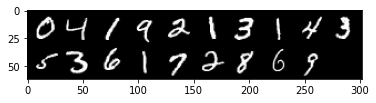

VAE reconstruction:


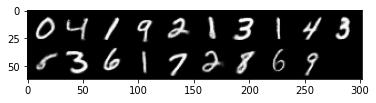

In [14]:
images, labels = iter(test_loader_mnist).next()

# First visualise the original images
print('Original images')
show_image(make_grid(images[1:20],10,2))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualize_reconstructions(images, vae)

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42, perplexity=60)

In [15]:
def get_all_images(data_loader):
    imgs_ = []
    labels_ = []
    for i in range(100):
        imgs, labels = next(iter(data_loader))
        imgs_.append(imgs)
        labels_.append(labels)

    imgs = torch.cat(imgs_, dim = 0)
    labels = torch.cat(labels_, dim = 0)
    return imgs, labels



In [17]:
imgs_mnist, labels_mnist = get_all_images(dataloader)
latent_z , _, _ = vae.encode(imgs_mnist.cuda())
tsne_z = tsne.fit_transform(latent_z.cpu().detach().numpy())
labels_mnist = labels_mnist.data.numpy()

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 12800 samples in 0.043s...
[t-SNE] Computed neighbors for 12800 samples in 11.964s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12800
[t-SNE] Computed conditional probabilities for sample 2000 / 12800
[t-SNE] Computed conditional probabilities for sample 3000 / 12800
[t-SNE] Computed conditional probabilities for sample 4000 / 12800
[t-SNE] Computed conditional probabilities for sample 5000 / 12800
[t-SNE] Computed conditional probabilities for sample 6000 / 12800
[t-SNE] Computed conditional probabilities for sample 7000 / 12800
[t-SNE] Computed conditional probabilities for sample 8000 / 12800
[t-SNE] Computed conditional probabilities for sample 9000 / 12800
[t-SNE] Computed conditional probabilities for sample 10000 / 12800
[t-SNE] Computed conditional probabilities for sample 11000 / 12800
[t-SNE] Computed conditional probabilities for sample 12000 / 12800
[t-SNE] Computed conditional probabilities for s

In [ ]:
latent_z.shape

torch.Size([12800, 30])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

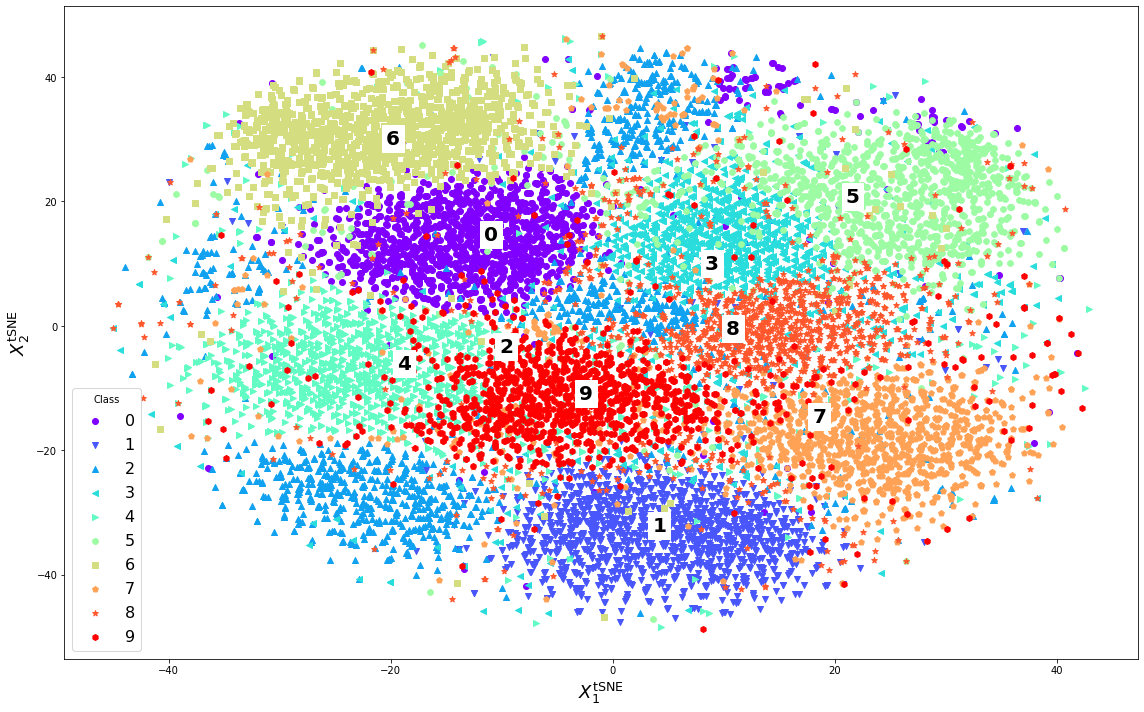

In [ ]:
nr_c = 10
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_z[idxs, 0],
                tsne_z[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.annotate(iclass, 
                 np.average([tsne_z[idxs ,0], tsne_z[idxs ,1]], axis=1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='black',
                 backgroundcolor='white') 
    plt.tight_layout()
    fig.savefig('tsne-pca.png')


*T-SNE on original dataset as a comparison to tsne on the latent space with latent dimensions = 64*

In [10]:
from sklearn.cluster import KMeans

In [11]:
from time import time
from sklearn import metrics

In [12]:
# accepts latent space from cluster GAN and vae and evaluates it. estimator - kmeans
def bench_latent_spaces(estimator, name, data, labels):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean'),
             metrics.davies_bouldin_score(data, estimator.labels_)))

In [ ]:
tsne_z.shape

(12800, 2)

In [ ]:
# kmeans on reduced latent space
bench_latent_spaces(KMeans(n_clusters=10, random_state=0), 'vae', tsne_z, labels_mnist)

vae      	0.68s	676443	0.573	0.574	0.574	0.532	0.573	0.391	0.797


In [ ]:
# test if the labels correspond to the right images 
# reconstruct the top 10 images and compare to the labels
reconstructed_images = vae.decode(latent_z[:10])
show_image(make_grid(reconstructed_images.detach().cpu(), 5, 2))

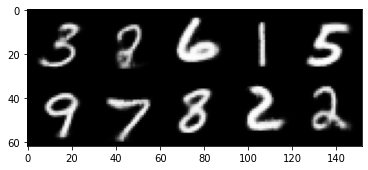

In [ ]:
labels[:10]

array([3, 2, 6, 1, 5, 9, 7, 8, 2, 2])

# FASHION MNIST

In [26]:
dataloader_fashion = DataLoader(
      FashionMNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

train_fashion_dataset = FashionMNIST('./mnist_data/', download= True, transform= transforms.ToTensor())
train_fashion_loader = DataLoader(train_fashion_dataset, batch_size= batch_size, shuffle= True)


test_fashion_dataset = FashionMNIST('./mnist_data/', download= False, transform= transforms.ToTensor())
test_fashion_loader = DataLoader(test_fashion_dataset, batch_size= batch_size, shuffle= False)

use_cuda = True

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


Extracting ./mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/FashionMNIST/raw


Extracting ./mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/FashionMNIST/raw





Extracting ./mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/FashionMNIST/raw


Extracting ./mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/FashionMNIST/raw
Processing...
Done!


In [ ]:
def train_fashion(epoch):
    vae_fashion.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_fashion_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae_fashion(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_fashion_loader.dataset),
                100. * batch_idx / len(train_fashion_loader), loss.item() / len(data)))
    print('==> Epoch: {} Average loss: {:.3f}'.format(epoch, train_loss / len(train_fashion_loader.dataset)))


def test_fashion():
    vae_fashion.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_fashion_loader:
            data = data.cuda()
            recon, mu, log_var = vae_fashion(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_fashion_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
vae_fashion = VAE(image_channels=1, h_dim = 128, z_dim = 30, use_cuda= use_cuda)
optimizer = optim.Adam(vae_fashion.parameters())
for epoch in range(n_epochs):
    train_fashion(epoch)
    test_fashion()

    if epoch % 10 == 0:
      torch.save(vae_fashion.state_dict(), '/content/gdrive/MyDrive/latent_space_clustering/vae/ankitha_runs/FashionMNIST/vae.pth')


NameError: ignored

In [28]:
# load from saved runs
vae_fashion = VAE(image_channels=1, h_dim = 128, z_dim = 30, use_cuda= use_cuda)
vae_fashion.load_state_dict(torch.load("/content/gdrive/MyDrive/latent_space_clustering/vae/ankitha_runs/FashionMNIST/vae.pth"))

<All keys matched successfully>

In [29]:
vae_fashion.eval()
vae_fashion.cuda()

VAE(
  (encoder): encoder(
    (conv2d1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (relu1): ReLU()
    (conv2d2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv2d3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (flatten): Flatten()
  )
  (fc1): Linear(in_features=128, out_features=30, bias=True)
  (fc2): Linear(in_features=128, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=128, bias=True)
  (decoder): decoder(
    (unflatten): UnFlatten()
    (tranconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (tranconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (tranconv3): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (tranconv4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (relu): ReLU()
    (sig): Sigmoid()
  )
)

Original images


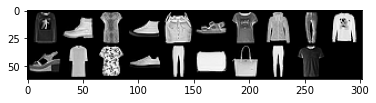

VAE reconstruction:


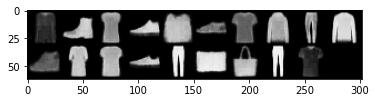

In [31]:
images, labels = iter(dataloader_fashion).next()

# First visualise the original images
print('Original images')
show_image(make_grid(images[1:20],10,2))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualize_reconstructions(images, vae_fashion)

In [32]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42, perplexity=50)
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(dataloader_fashion))
    imgs_.append(imgs)
    labels_.append(labels)

imgs = torch.cat(imgs_, dim = 0)
fashion_labels_num = torch.cat(labels_, dim = 0)

#latent_z_fashion , _, _ = vae_fashion.encode(imgs.cuda())
#tsne_z_fashion = tsne.fit_transform(latent_z_fashion.cpu().detach().numpy())
fashion_labels_num = fashion_labels_num.data.numpy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

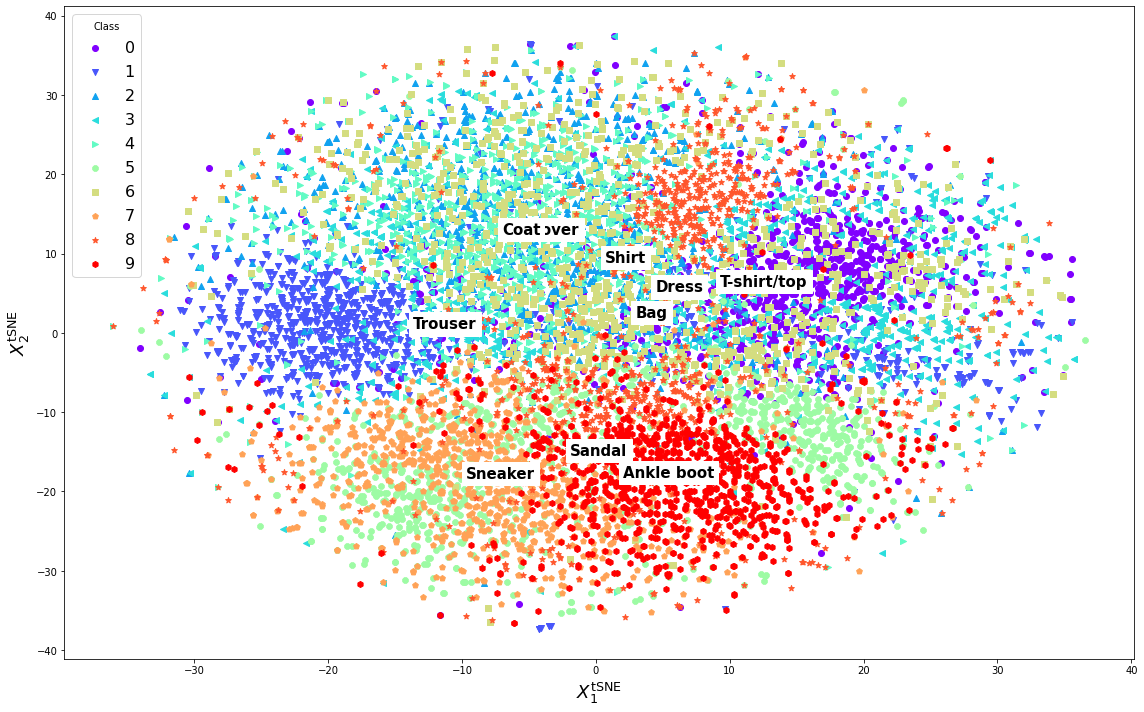

In [27]:
fashion_labels = ["T-shirt/top", "Trouser" ,"Pullover", "Dress" ,"Coat",
                 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
nr_c = 10
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = fashion_labels_num==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_z_fashion[idxs, 0][:1000],
                tsne_z_fashion[idxs, 1][:1000],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.annotate(fashion_labels[iclass], 
                 np.average([tsne_z_fashion[idxs ,0], tsne_z_fashion[idxs ,1]], axis=1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=15, weight='bold',
                 color='black',
                 backgroundcolor='white') 
    plt.tight_layout()
    fig.savefig('tsne-pca-fashion.png')

In [28]:
bench_latent_spaces(KMeans(n_clusters=10), 'vae_fashion', tsne_z_fashion, fashion_labels_num)

vae_fashion	0.83s	682780	0.316	0.316	0.316	0.212	0.315	0.340	0.825


# Clustering Accuracy

In [29]:
#from scipy.optimize import linear_sum_assignment
from sklearn.utils.linear_assignment_ import linear_assignment
def clustering_acc(y_pred, y_true):
    D = int(max(y_pred.max(), y_true.max()) + 1)
    w = np.zeros((D, D), dtype=np.int32)
    for i in range(y_pred.size):
        idx1 = int(y_pred[i])
        idx2 = int(y_true[i])
        w[idx1, idx2] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [30]:
kmeans_mnist = KMeans(n_clusters=10)
kmeans_mnist.fit(tsne_z_fashion)
clustering_acc(kmeans_mnist.labels_, fashion_labels_num)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.3840625

In [ ]:
kmeans_ = KMeans(n_clusters = 10)
kmeans_.fit(tsne_z)
clustering_acc(kmeans_.labels_, labels_mnist)

# Similar image generation

In [22]:
def generate_similar_image(img, model, deviation_param=0.02):
  img = img.unsqueeze(0)
  enc_z, _, _ = model.encode(img)
  new_enc_z = enc_z + torch.normal(mean=torch.zeros_like(enc_z), std = deviation_param * torch.ones_like(enc_z))
  similar_image = model.decode(new_enc_z)
  plt.subplot(1,2,2)
  plt.imshow(similar_image.reshape((28,28)).detach().cpu(), cmap='gray')
  plt.xlabel("Similar Image")
  plt.subplot(1,2,1)
  plt.imshow(img.reshape((28,28)).detach().cpu(), cmap="gray")
  plt.xlabel("Original Image")
  plt.ylabel(f"Adding noise with std {deviation_param} to the latent vector")

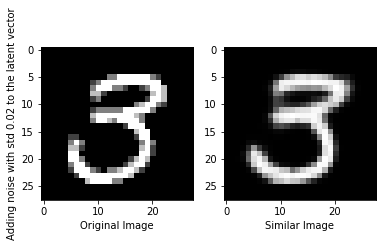

In [34]:
generate_similar_image(imgs_mnist[120].cuda(), vae, deviation_param=0.02)

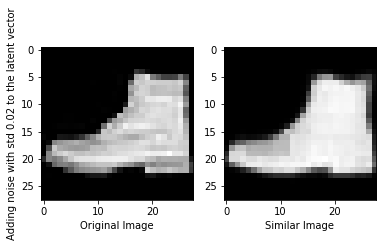

In [45]:
generate_similar_image(images[2].cuda(), vae_fashion, deviation_param=0.02)

# K similar images

In [53]:
import heapq

In [46]:
def recommend_k_similar_images(img,model, other_imgs, k=5):
  img = img.unsqueeze(0) 
  img_z, _, _ = model.encode(img)
  other_z, _, _ = model.encode(other_imgs)
  similarity_dict = {}
  cos = nn.CosineSimilarity(dim=1, eps=1e-6)
  for idx in range(other_imgs.shape[0]):
    img_vec = torch.cat([img_z], dim=1)
    compare_img_vec = torch.cat([other_z[idx, :].unsqueeze(0)], dim=1)
    similarity_dict[idx] = cos(img_vec, compare_img_vec).item()
  k_keys_sorted_by_values = heapq.nlargest(k, similarity_dict, key=similarity_dict.get)
  return other_imgs[k_keys_sorted_by_values, :]

In [47]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_recommended_images(given_img, model, other_imgs, how_many=5):
  rec_imgs = recommend_k_similar_images(given_img, model, other_imgs, k=how_many)
  plt.subplot(1,2,1)
  plt.imshow(given_img.reshape((28,28)).detach().cpu(), cmap="gray")
  plt.xlabel("Actual Image")
  plt.title(f"Recommending {how_many} images based on cosine similarity of latent vectors")
  plt.subplot(1,2,2)
  show_image(make_grid(rec_imgs.detach().cpu(), how_many, 1))
  plt.xlabel("Recommended Images")


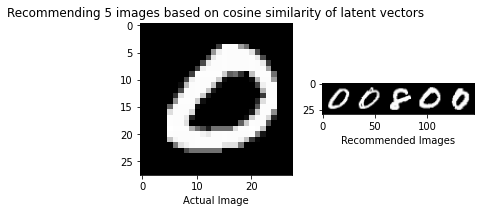

In [54]:
show_recommended_images(imgs_mnist[110].cuda(), vae, imgs_mnist.cuda())

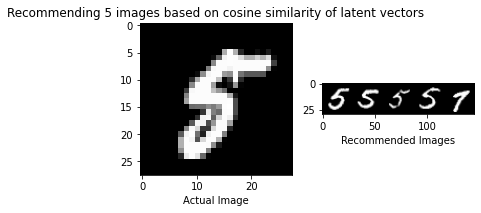

In [55]:
show_recommended_images(imgs_mnist[100].cuda(), vae, imgs_mnist.cuda())

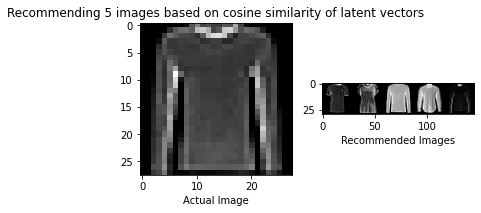

In [72]:
show_recommended_images(imgs[46].cuda(), vae_fashion, imgs.cuda())

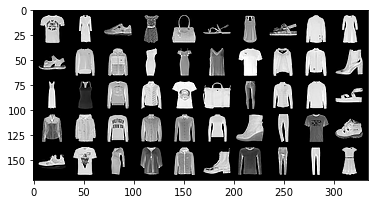

In [67]:
show_image(make_grid(imgs[:50].detach().cpu(), 10, 5))